In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import constants
#sns.set_theme()
import re
import utils
from scipy import ndimage
from scipy.signal import lfilter


In [2]:
c = constants.c
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
frame_rate =50*10**(-3) # frame rate
sample_per_frame = 260*257 # sample pr frame
c_t = (1/sample_bandwidth )*256 # sample period
#fs_new = 1/sample_period_new # sample frekuenzy 

# Read textfile

In [3]:
#Record_2022-09-27_14-14-14.bin
try:
    #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
    #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
    with open("felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin", "rb") as f:

        data = f.read()
    
        
        
except IOError as e:
    print(e)

In [4]:
stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
    ls = re.search(stri.encode(), data_bytes).end()
    data_arr.append(data_bytes[:ls])
    data_bytes = data_bytes[ls+4:]
    print(len(data_bytes))
    if(len(data_bytes) == 0):
        done = True

725850672
724801916
723753136
722704392
721655612
720606868
719558112
718509392
717460660
716411904
715363148
714314380
713265588
712216796
711168028
710119236
709070456
708021664
706972884
705924116
704875336
703826556
702777764
701728996
700680192
699631364
698582548
697533708
696484880
695436064
694387248
693338480
692289712
691240944
690192152
689143360
688094604
687045860
685997104
684948312
683899532
682850776
681802008
680753264
679704520
678655776
677606960
676558156
675509412
674460620
673411828
672363072
671314304
670265548
669216780
668168012
667119232
666070428
665021624
663972784
662923992
661875224
660826396
659777604
658728824
657680056
656631300
655582532
654533752
653484972
652436204
651387424
650338680
649289924
648241156
647192424
646143668
645094900
644046132
642997328
641948536
640899756
639850940
638802148
637753368
636704552
635655748
634606992
633558212
632509384
631460580
630411788
629362984
628314180
627265352
626216560
625167780
624118940
623070116
622021256


# Neq algo

In [5]:
def simple_exp_smooth(d,extra_periods=1,alpha=0.4):  
  #d = np.array(d)  # Transform the input into a numpy array  
  cols = len(d)  # Historical period length  
  #d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
  f = np.zeros_like(d)  # Forecast array  
  f[0] = d[1]  # initialization of first forecast  
 
  # Create all the t+1 forecasts until end of historical period  
  for t in range(1,cols):  
    f[t] = alpha*d[t]+(1-alpha)*f[t-1]
  #print(f)  
  f[cols+1:] = f[t]  # Forecast for all extra periods  
  #df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f})
  return f,d

In [6]:
def ewma_filter(alpha):
  '''
  Filter coefficients for a recursive exponentially weighted moving average
  '''
  alpha = float(alpha)
  assert 0 <= alpha <= 1
  b, a = [alpha], [1, -(1.-alpha)]
  return b, a

def ewma(x, alpha, v0=0):
  '''
  Causal exponential moving average implemented using scipy.signal.lfilter.
  With alpha as the forgetting factor close to one, x the signal to filter.
  Optionally, an initial estimate can be provided with the float v0.
  '''
  b,a = ewma_filter(alpha)
  #x = np.atleast_1d(x).flatten()
  v0 = float(v0)
  sos = signal.tf2sos(a=a,b=b)
  
  #return signal.lfilter(b, a, x, zi=zi,axis=0)

  

  return signal.sosfilt(sos, x,axis=0,zi=zi)

In [7]:
def background_update(frames):
    MRDM =np.zeros((len(frames),256,256),dtype=np.complex_)
    for i,frame in enumerate(frames):
        length = int.from_bytes(
                 frame[4:8], byteorder="little", signed=False)
        data_RADC = frame[8:8+length]
        data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
        data_RADC = data_RADC.reshape(3,256,512)
        data_RADC_I_raw = data_RADC[:,:,::2]
        data_RADC_Q_raw = data_RADC[:,:,1::2]
        data_RADC_I = detrend(data_RADC_I_raw, axis=2)
        data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)

        data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
        data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
        data_IF = signal.windows.hann(256)*data_RADC_I_mean[:,:] + signal.windows.hann(256)*1j*data_RADC_Q_mean[:,:]
        data_range_baseline =utils.fft_and_plot(data_IF, axis=1, fs=1,fft_size=256,plot=False,shift =False)
       
        for j in range(256):
            data_range_baseline[:,j] = signal.windows.hann(256)*data_range_baseline[:,j]
        data_doppler_window_slow = utils.fft_and_plot(data_range_baseline, axis=0, fs=sample_frek,fft_size=256,shift =True)
        MRDM[i]=data_doppler_window_slow
    alpha = 1/128 # smoothing coefficient
    return simple_exp_smooth(MRDM,alpha =alpha
    )
   
    
    return ewma(MRDM[10:],alpha=alpha),MRDM
  

In [8]:
# idx = 450
# data_ma,raw_t = background_update(data_arr[:idx])


In [9]:
# data_diff = np.abs(raw_t) -np.abs(data_ma)
# print(data_diff.shape)


In [10]:
# data_ma,raw = simple_exp_smooth(data_diff,alpha =1/256
#     )
# data_diff = np.abs(raw) -np.abs(data_ma)
# data_ma,raw = simple_exp_smooth(data_diff,alpha =1/256
#     )
# data_diff = np.abs(raw[-1]) -np.abs(data_ma[-1])
# print(data_diff.shape)

In [11]:
# labels = {
#     "x_label":"Velocity [knots]",
#     "y_label":"Range [m]",
#     "title": "Range-Doppler Map"

# }
# #data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
# #data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
# #sns.set(rc={'figure.figsize':(20,15)})
# plt.figure(figsize=(20,15))
# rotated_img = ndimage.rotate(np.abs(data_ma[-1]),90) # We rotate the image so the x axis is the velocity
# #rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
# plt.imshow(rotated_img,cmap="plasma", vmin=0,vmax=100000)
# print(np.max(rotated_img[137,87]))
# print(np.mean(rotated_img[139,:]))
# print((np.max(rotated_img[137,87])-np.mean(rotated_img[139,:]))/np.max(rotated_img[137,87]))       
# plt.yticks(np.linspace(0,256,5),labels=np.round(np.linspace(255*0.785277,0,5)),size =15)


# plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
# cbar  = plt.colorbar()
# cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
# cbar.ax.tick_params(labelsize=15) 
# plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
# plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
# plt.title(labels["title"],fontdict = {'fontsize' : 30})
# plt.grid(False)

In [12]:
# plt.figure(figsize=(60,60))
# data_abs = 20*np.log(np.abs(data_ma[-1]))
#     #data_abs = np.delete(data_abs,0,axis=1)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    


#     # Make data.
# X = np.arange(0, 256, 1)
# Y = np.arange(0, 256, 1)
# X, Y = np.meshgrid(X, Y)
# #ata_abs[data_abs<zlim_min]= np.nan
   
    

#     # Plot the surface.
# surf = ax.plot_surface(X, Y, data_abs, cmap=cm.coolwarm,
#                         linewidth=0, antialiased=False, vmin=150,vmax=170)
#     #ax.set_zlim(zlim_min, zlim_max)
    
# ax.set_xticks(np.linspace(0,256,5),labels=np.round(np.linspace(0,255*0.785277,5)),size =10)
    
        
# ax.set_yticks(np.linspace(0,256,5),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,5),1),size =10)
# ax.set_zlabel("Magnitude [dB]")
# ax.set_ylabel("Velocity [knots]")
# ax.set_xlabel("Range [m]")
# #ax.set_zlim(zlim_min,zlim_max+30)
    
# cbar = fig.colorbar(surf, ax=ax ,shrink=0.5, aspect=5)
# cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 10})
# cbar.ax.tick_params(labelsize=10) 


# plt.show()

In [13]:
# labels = {
#     "x_label":"Velocity [knots]",
#     "y_label":"Range [m]",
#     "title": "Range-Doppler Map"

# }
# #data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
# #data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
# #sns.set(rc={'figure.figsize':(20,15)})
# plt.figure(figsize=(20,15))
# rotated_img = ndimage.rotate(np.abs(data_diff),90) # We rotate the image so the x axis is the velocity
# #rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
# plt.imshow(rotated_img,cmap="plasma", vmin=0,vmax=100000)
# print(np.max(rotated_img[137,87]))
# print(np.mean(rotated_img[139,:]))
# print((np.max(rotated_img[137,87])-np.mean(rotated_img[139,:]))/np.max(rotated_img[137,87]))  
# #plt.yticks(np.linspace(0,256,5),labels=np.round(np.linspace(255*0.785277,0,5)),size =15)
# #plt.xlim(60,100)
# #plt.ylim(130,150)
# #plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
# cbar  = plt.colorbar()
# cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
# cbar.ax.tick_params(labelsize=15) 
# plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
# plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
# plt.title(labels["title"],fontdict = {'fontsize' : 30})
# plt.grid(False)

In [14]:
# plt.figure(figsize=(60,60))
# data_abs = 20*np.log(np.abs(data_diff))
#     #data_abs = np.delete(data_abs,0,axis=1)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    


#     # Make data.
# X = np.arange(0, 256, 1)
# Y = np.arange(0, 256, 1)
# X, Y = np.meshgrid(X, Y)
# #ata_abs[data_abs<zlim_min]= np.nan
   
    

#     # Plot the surface.
# surf = ax.plot_surface(X, Y, data_abs, cmap=cm.coolwarm,
#                         linewidth=0, antialiased=False, vmin=150,vmax=200)
#     #ax.set_zlim(zlim_min, zlim_max)
    
# #ax.set_xticks(np.linspace(0,256,5),labels=np.round(np.linspace(0,255*0.785277,5)),size =10)
    
        
# ax.set_yticks(np.linspace(0,256,5),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,5),1),size =10)
# ax.set_zlabel("Magnitude [dB]")
# ax.set_ylabel("Velocity [knots]")
# ax.set_xlabel("Range [m]")
# #ax.set_zlim(zlim_min,zlim_max+30)
    
# cbar = fig.colorbar(surf, ax=ax ,shrink=0.5, aspect=5)
# cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 10})
# cbar.ax.tick_params(labelsize=10) 


# plt.show()

In [15]:
# labels = {
#     "x_label":"Velocity [knots]",
#     "y_label":"Range [m]",
#     "title": "Range-Doppler Map"

# }
# #data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
# #data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
# #sns.set(rc={'figure.figsize':(20,15)})
# plt.figure(figsize=(20,15))
# rotated_img = ndimage.rotate(np.abs(raw_t[-1]),90) # We rotate the image so the x axis is the velocity
# plt.imshow(rotated_img,cmap="plasma",  vmin=0,vmax=100000)
# print(np.max(rotated_img[137,87]))
# print(np.mean(rotated_img[139,:]))
# print((np.max(rotated_img[137,87])-np.mean(rotated_img[139,:]))/np.max(rotated_img[137,87]))     
# #plt.yticks(np.linspace(0,256,5),labels=np.round(np.linspace(255*0.785277,0,5)),size =15)


# #plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2)
# #plt.xlim(85,90)
# #plt.ylim(135,140)
# cbar  = plt.colorbar()
# cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
# cbar.ax.tick_params(labelsize=15) 
# plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
# plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
# plt.title(labels["title"],fontdict = {'fontsize' : 30})
# plt.grid(False)


In [16]:
# plt.figure(figsize=(60,60))
# data_abs = 20*np.log(np.abs(raw_t))
#     #data_abs = np.delete(data_abs,0,axis=1)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    


#     # Make data.
# X = np.arange(0, 256, 1)
# Y = np.arange(0, 256, 1)
# X, Y = np.meshgrid(X, Y)
# #ata_abs[data_abs<zlim_min]= np.nan
   
    

#     # Plot the surface.
# surf = ax.plot_surface(X, Y, data_abs, cmap=cm.coolwarm,
#                         linewidth=0, antialiased=False, vmin=150,vmax=200)
#     #ax.set_zlim(zlim_min, zlim_max)
    
# ax.set_xticks(np.linspace(0,256,5),labels=np.round(np.linspace(0,255*0.785277,5)),size =10)
    
        
# ax.set_yticks(np.linspace(0,256,5),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,5),1),size =10)
# ax.set_zlabel("Magnitude [dB]")
# ax.set_ylabel("Velocity [knots]")
# ax.set_xlabel("Range [m]")
# #ax.set_zlim(zlim_min,zlim_max+30)
    
# cbar = fig.colorbar(surf, ax=ax ,shrink=0.5, aspect=5)
# cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 10})
# cbar.ax.tick_params(labelsize=10) 


# plt.show()

# Format data

In [17]:
frame_nr = 340
data_type = data_arr[frame_nr][:4].decode()
print("TYPE: ", data_type)
length = int.from_bytes(
   data_arr[frame_nr][4:8], byteorder="little", signed=False)
print("length:", length)
data_RADC = data_arr[frame_nr][8:8+length]
print(len(data_RADC))

data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
data_RADC = data_RADC.reshape(3,256,512)
data_RADC_I_raw = data_RADC[:,:,::2]
data_RADC_Q_raw = data_RADC[:,:,1::2]
data_RADC_I = detrend(data_RADC_I_raw, axis=2)
data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)

#data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
#data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
data_RADC_I_mean = data_RADC_I[0]
data_RADC_Q_mean = data_RADC_Q[0]
window = signal.windows.hamming(256)
#Convert it to a complex format
#data_IF = signal.windows.hann(256)*data_RADC_I_mean[:,:] + signal.windows.hann(256)*1j*data_RADC_Q_mean[:,:]
data_IF = window*data_RADC_I_mean[:,:] + window*1j*data_RADC_Q_mean[:,:]
#data_IF = signal.windows.hann(256)*data_RADC_I[0,:,:] + signal.windows.hann(256)*1j*data_RADC_Q[0,:,:]

TYPE:  RADC
length: 786432
786432


# Plot Raw ADC data

<Figure size 10000x3000 with 0 Axes>

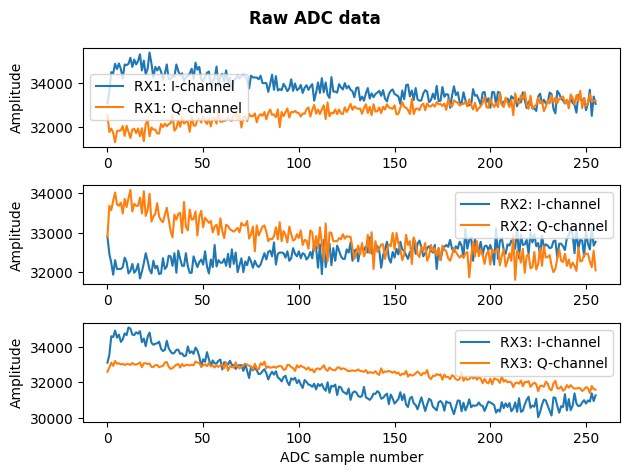

In [18]:
plt.figure(figsize=(100,30))
fig, axs = plt.subplots(3, 1)
axs[0].plot(data_RADC_I_raw[0,100,:],label = "RX1: I-channel")
axs[0].plot(data_RADC_Q_raw[0,100,:],label = "RX1: Q-channel")
axs[0].legend()
axs[0].set_ylabel("Amplitude")

axs[1].plot(data_RADC_I_raw[1,100,:],label = "RX2: I-channel")
axs[1].plot(data_RADC_Q_raw[1,100,:],label = "RX2: Q-channel")
axs[1].legend()
axs[1].set_ylabel("Amplitude")

axs[2].plot(data_RADC_I_raw[2,100,:],label = "RX3: I-channel")
axs[2].plot(data_RADC_Q_raw[2,100,:],label = "RX3: Q-channel")
axs[2].legend()
axs[2].set_ylabel("Amplitude")
plt.xlabel("ADC sample number")
fig.suptitle('Raw ADC data',weight="bold")
fig.tight_layout()

plt.savefig("plots/raw_adc.svg",format="svg")



plt.show()

## detrend

<Figure size 2000x1500 with 0 Axes>

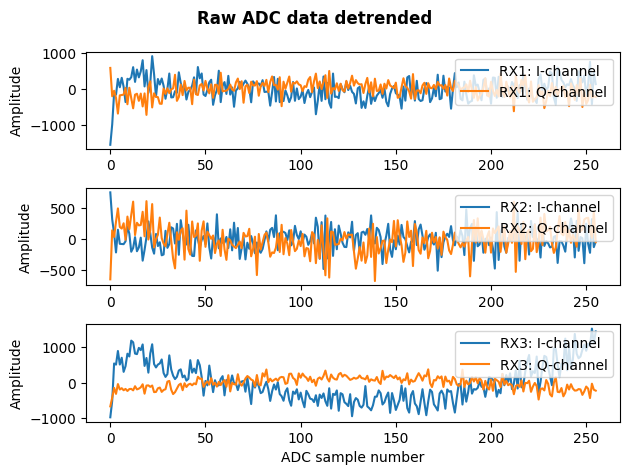

In [19]:
plt.figure(figsize=(20,15))
fig, axs = plt.subplots(3, 1)
axs[0].plot(data_RADC_I[0,100,:],label = "RX1: I-channel")
axs[0].plot(data_RADC_Q[0,100,:],label = "RX1: Q-channel")
axs[0].legend(loc = "upper right")
axs[0].set_ylabel("Amplitude")

axs[1].plot(data_RADC_I[1,100,:],label = "RX2: I-channel")
axs[1].plot(data_RADC_Q[1,100,:],label = "RX2: Q-channel")
axs[1].legend(loc = "upper right")
axs[1].set_ylabel("Amplitude")

axs[2].plot(data_RADC_I[2,100,:],label = "RX3: I-channel")
axs[2].plot(data_RADC_Q[2,100,:],label = "RX3: Q-channel")
axs[2].legend(loc = "upper right")
axs[2].set_ylabel("Amplitude")
plt.xlabel("ADC sample number")
fig.suptitle('Raw ADC data detrended',weight="bold")
fig.tight_layout()

plt.savefig("plots/raw_adc_detrend.svg",format="svg")



plt.show()

<Figure size 2000x1500 with 0 Axes>

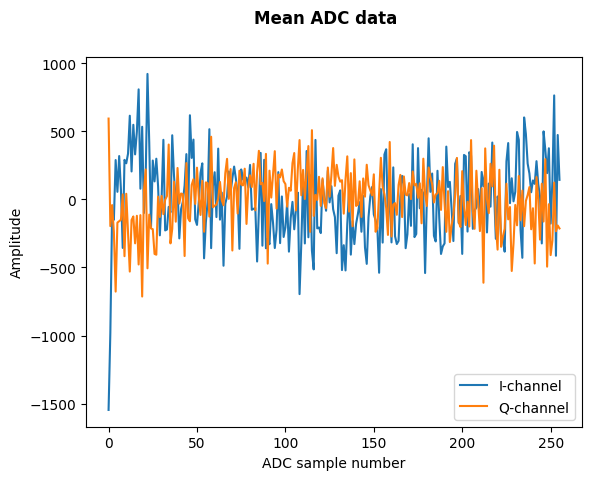

In [20]:
plt.figure(figsize=(20,15))
fig, axs = plt.subplots(1, 1)
axs.plot(data_RADC_I_mean[100,:],label = "I-channel")
axs.plot(data_RADC_Q_mean[100,:],label = "Q-channel")
axs.legend()
axs.set_ylabel("Amplitude")
plt.xlabel("ADC sample number")
fig.suptitle('Mean ADC data',weight="bold")
plt.savefig("plots/mean_adc.svg",format="svg")




# Windowing

<Figure size 2000x1500 with 0 Axes>

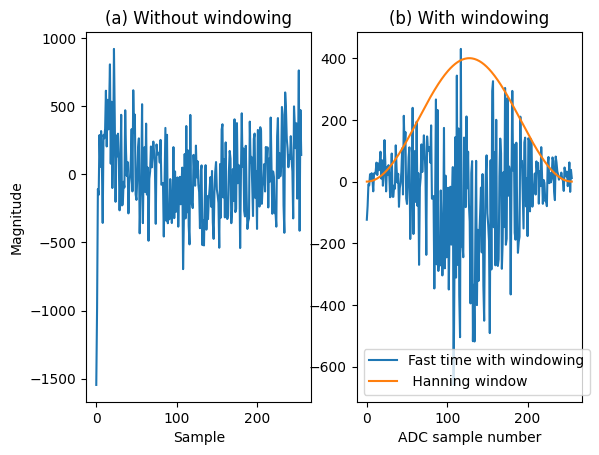

In [21]:
plt.figure(figsize=(20,15))
fig, axs = plt.subplots(1, 2)
axs[0].plot(data_RADC_I_mean[100,:],label ="Fast time without winfowing")

axs[0].set_ylabel("Magnitude")
axs[0].set_xlabel("Sample")

#axs[0].set_xlim(8,12)
#axs[0].set_ylim(-10,50)

axs[0].set_title("(a) Without windowing")


axs[1].plot(np.real(data_IF[100,:]), label ="Fast time with windowing")
axs[1].plot(signal.windows.hann(256)*400, label =" Hanning window")


#axs[1].set_ylabel("Magnitude")
axs[1].set_xlabel("Sample")
#axs[1].set_xlim(8,12)
#axs[1].set_ylim(-10,50)
axs[1].set_title("(b) With windowing")
axs[1].legend()



plt.xlabel("ADC sample number")
#fig.suptitle('Raw ADC data detrended')

#

#fig.tight_layout()
plt.savefig("plots/fasttime_hannn.svg",format="svg")
plt.show()


In [22]:
plot_min_range = 40
plot_max_range = 120
plot_min_doppler = 100
plot_max_doppler = 150
plot_min_3d = 80
plot_max_3d = 95

# Waveform compression

Peak: 34.07133979154021
Side loab: 32.175426507635606
RMS: 36.82211283010266
SNR: -2.75077303856245


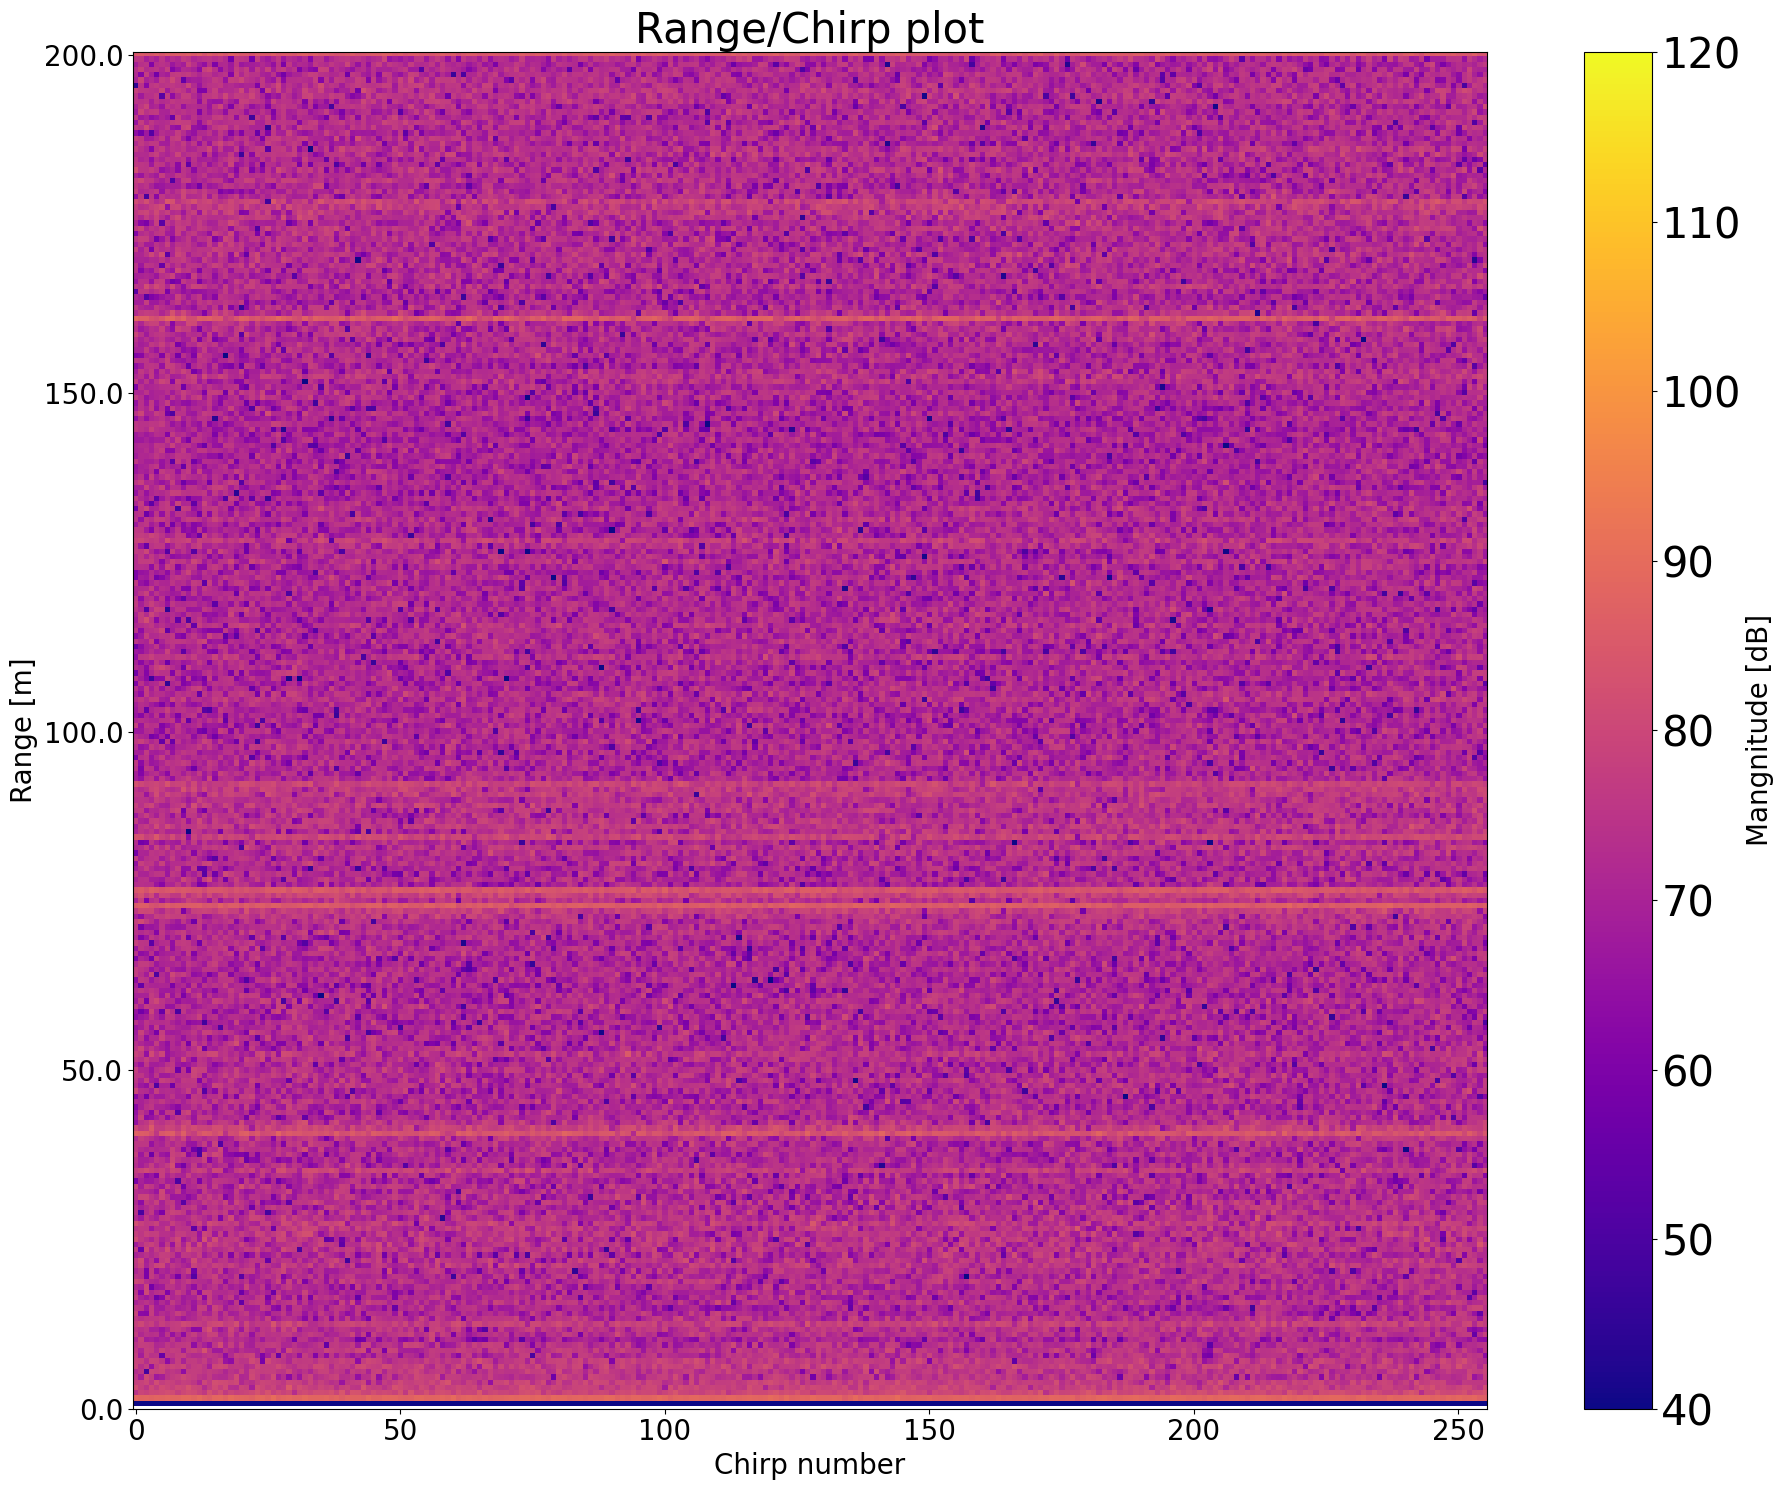

In [23]:
labels = {
    "x_label":"Chirp number",
    "y_label":"Range [m]",
    "title": "Range/Chirp plot"

}
data_IF_no_win = data_RADC_I_mean + 1j*data_RADC_Q_mean
data_range_baseline =utils.fft_and_plot(data_IF_no_win, axis=1, fs=1,fft_size=256,plot=True,shift =False,vmin=plot_min_range,vmax=plot_max_range, labels= labels,savefig=True,figname="range_fft_baseline")


# Basline doppler compression

Peak: 48.93224038716393
Side loab: 47.52646891270943
RMS: 47.7251370092537
SNR: 1.2071033779102294


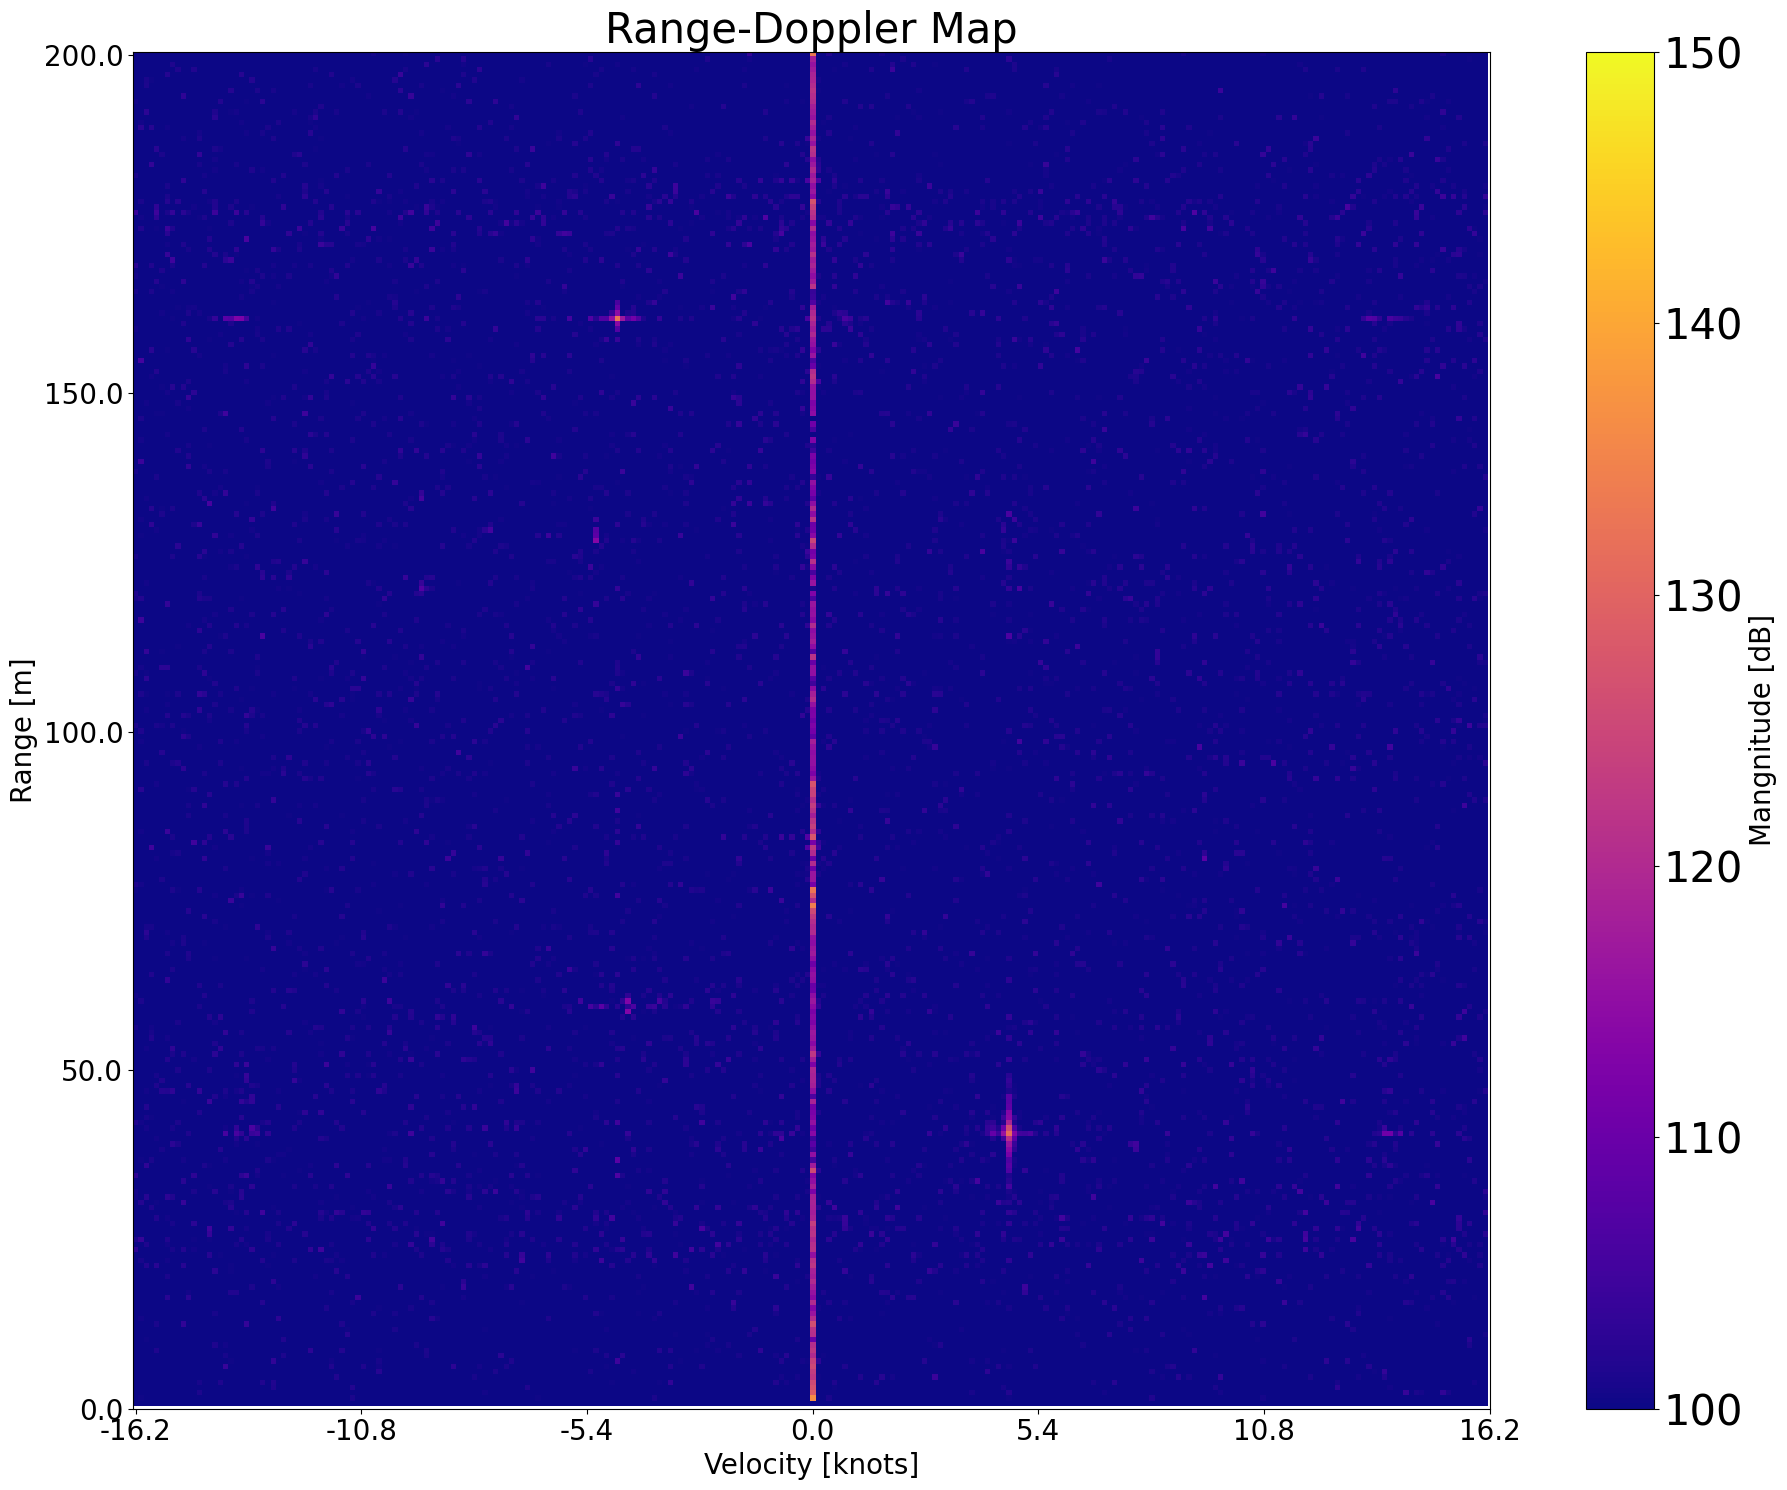

In [24]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
data_doppler_baseline = utils.fft_and_plot(data_range_baseline, axis=0, fs=sample_frek,fft_size=256,plot=True,shift =True,vmin=plot_min_doppler,vmax=plot_max_doppler, doppler= True,labels=labels,savefig=True, figname="Range-Doppler_nofilter_nowindow",dB=True, mode=1)


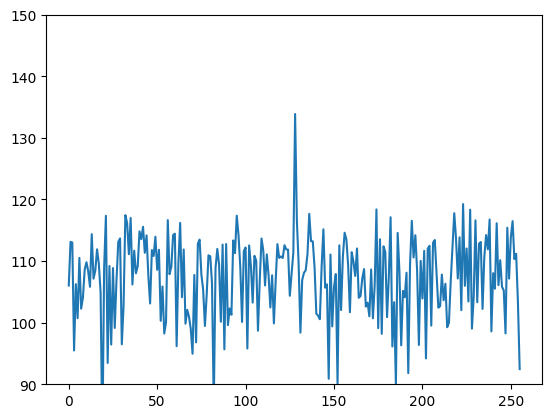

In [25]:
roteted_data =ndimage.rotate( data_doppler_baseline,90)
plt.plot( 10*np.log(np.abs( roteted_data[137,:])))
plt.ylim(90,150)
plt.show()

<Figure size 6000x6000 with 0 Axes>

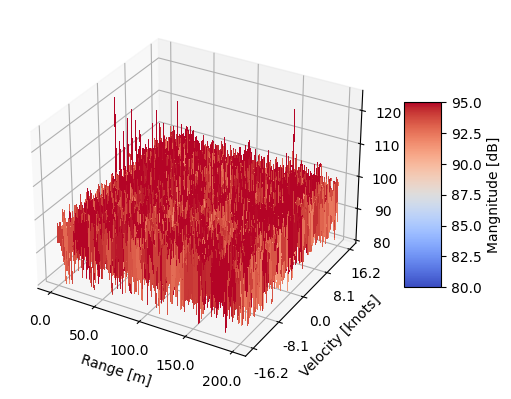

In [26]:
utils.plot_3D(data_doppler_baseline,figname="3dDoppler_baseline",zlim_min=plot_min_3d,zlim_max=plot_max_3d)

# Windowing

## Fast time

Peak: 32.43069982581264
Side loab: 32.271282929792676
RMS: 34.36005748189242
SNR: -1.9293576560797803


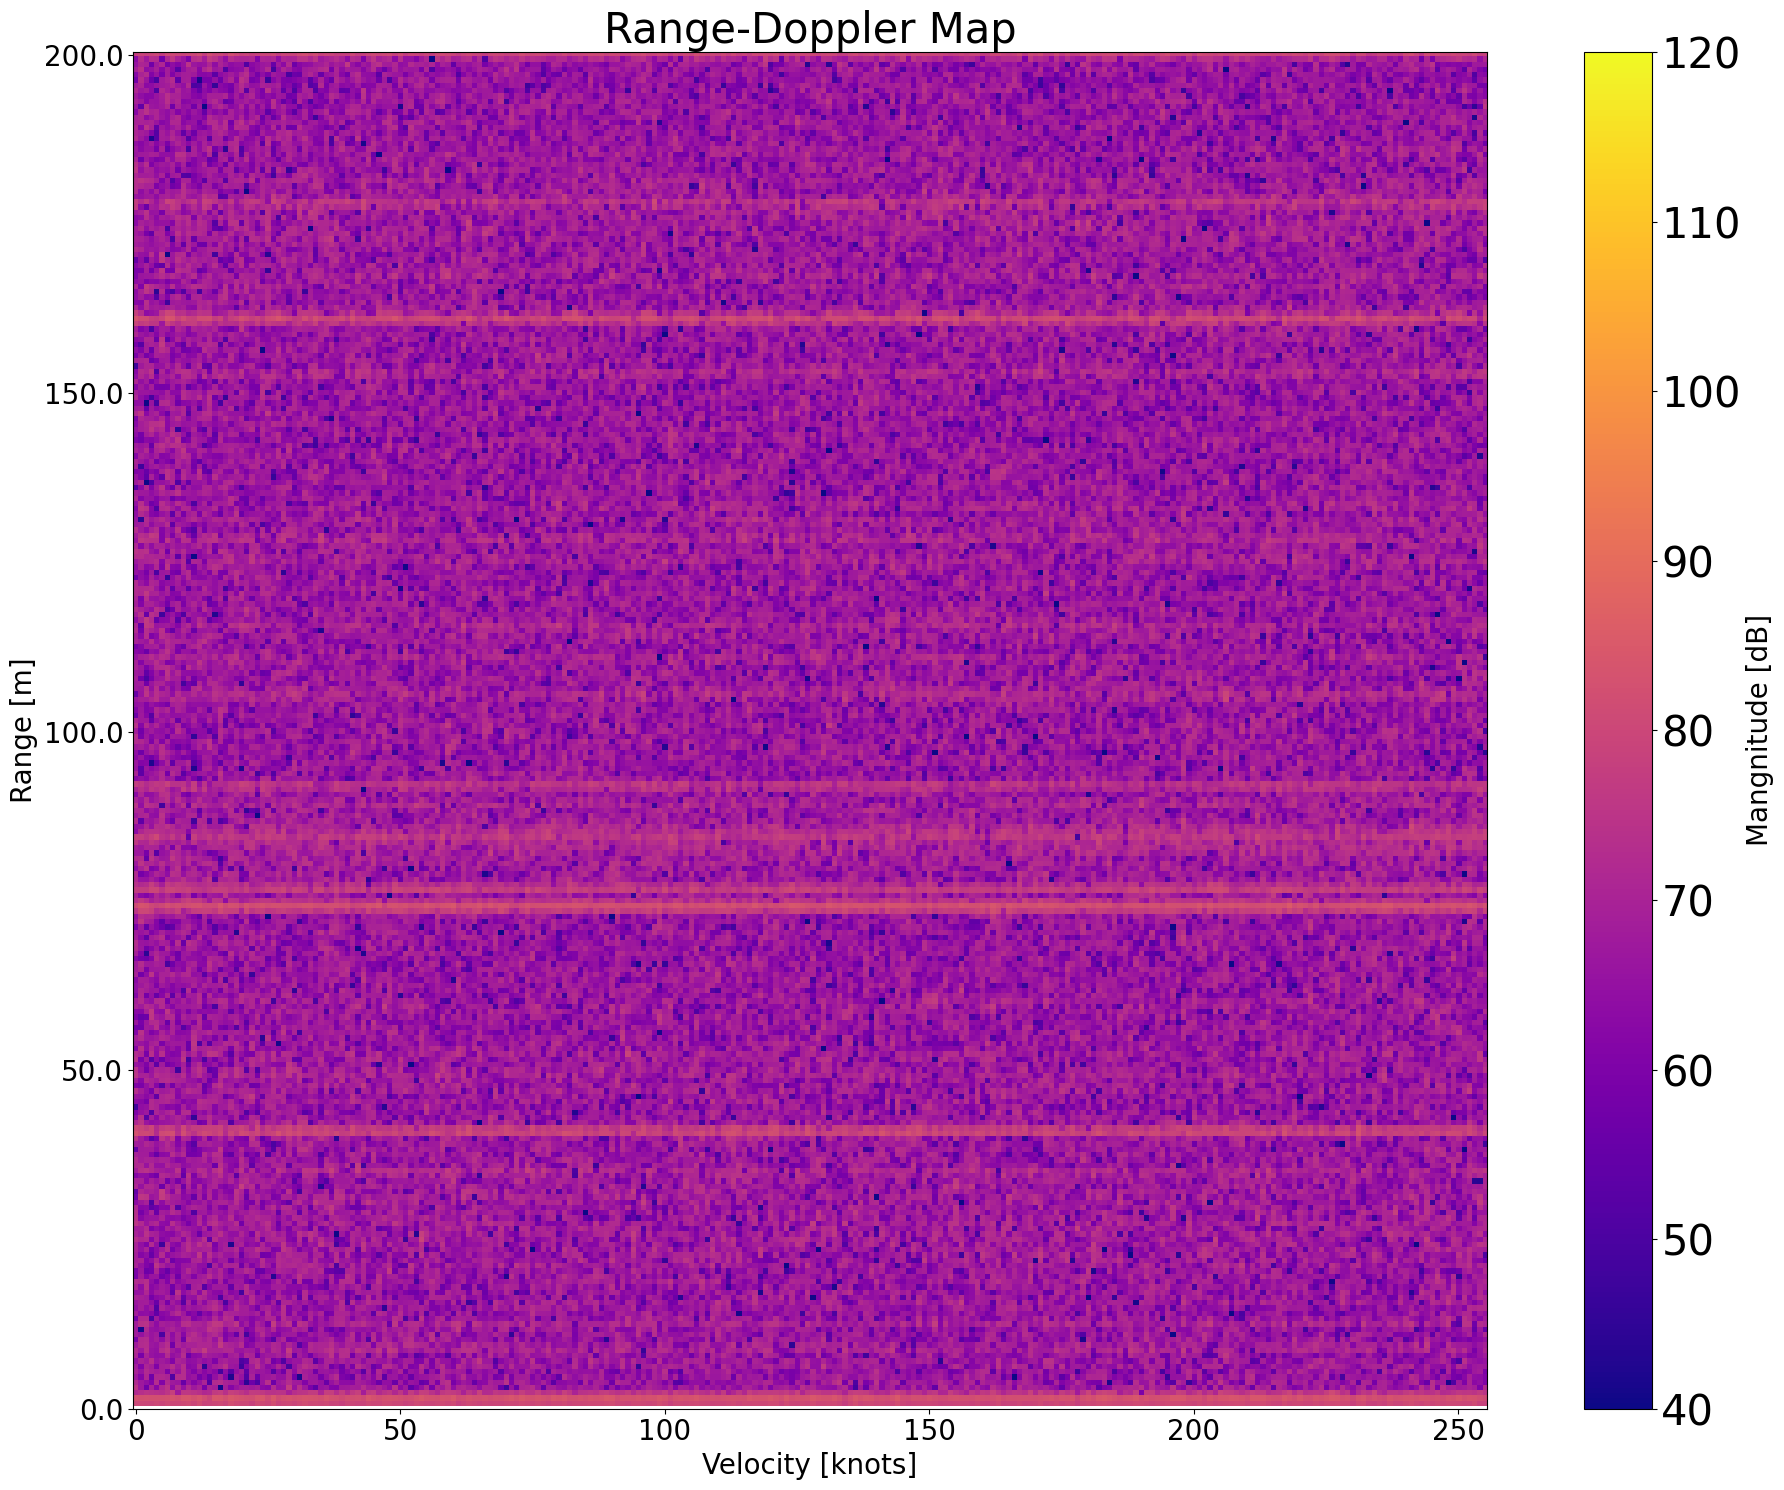

In [27]:
data_range_windowed =utils.fft_and_plot(data_IF, axis=1, fs=1,fft_size=256,plot=True,shift =False,vmin=plot_min_range,vmax=plot_max_range, labels= labels,savefig=True,figname="range_fft_windowed")


## Slowtime

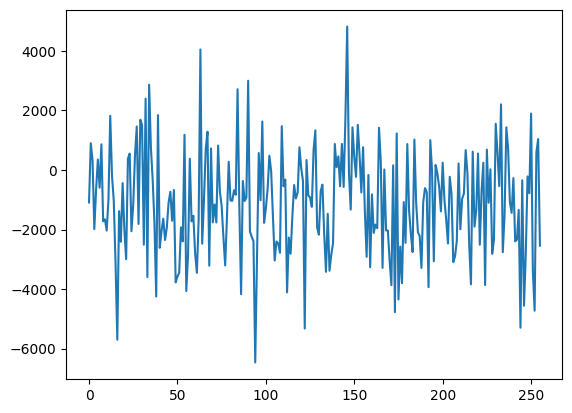

In [28]:
plt.plot(np.real(data_range_windowed[:,60]))

In [29]:
data_range_baseline_window = data_range_windowed.copy()
for i in range(256):
    data_range_baseline_window[:,i] = window*data_range_baseline[:,i]

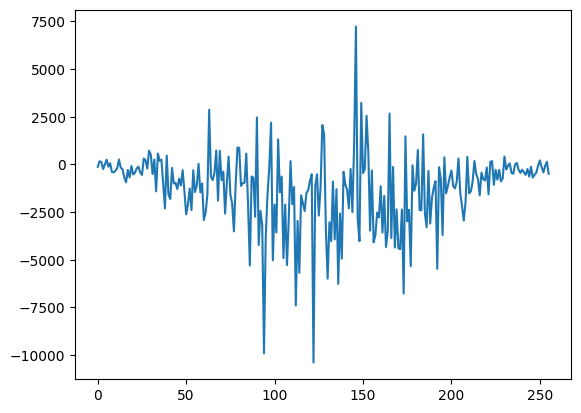

In [30]:
plt.plot(np.real(data_range_baseline_window[:,60]))

Peak: 46.15780147399128
Side loab: 41.83630478077493
RMS: 45.61678771244541
SNR: 0.5410137615458694


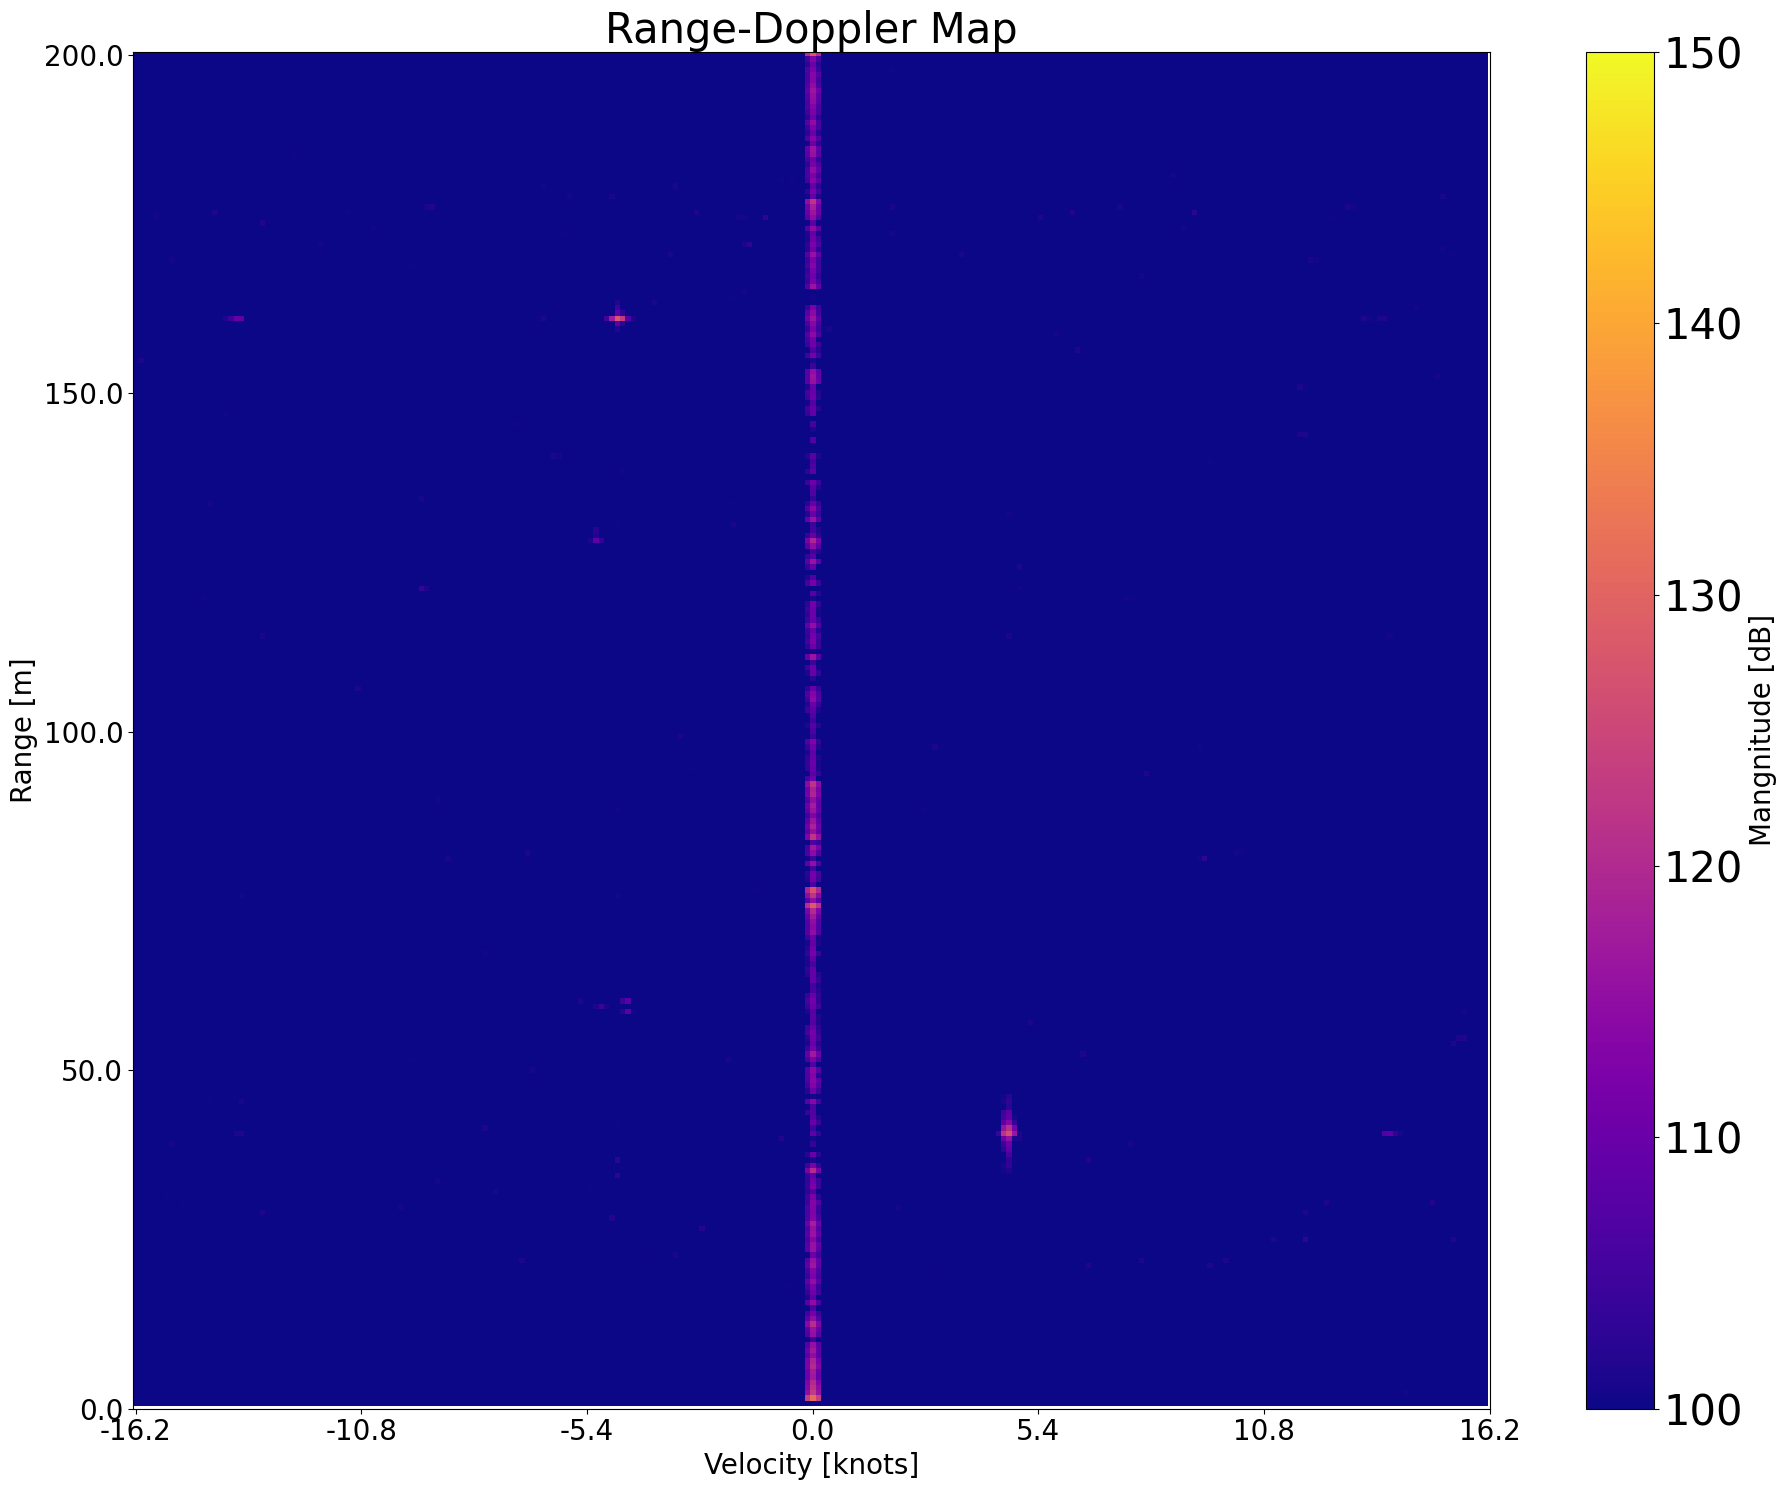

In [31]:
data_doppler_window_slow = utils.fft_and_plot(data_range_baseline_window, axis=0, fs=sample_frek,fft_size=256,plot=True,shift =True,vmin=plot_min_doppler,vmax=plot_max_doppler, doppler= True,labels=labels,savefig=True, figname="Range-Doppler_windowed", dB=True, mode=1)

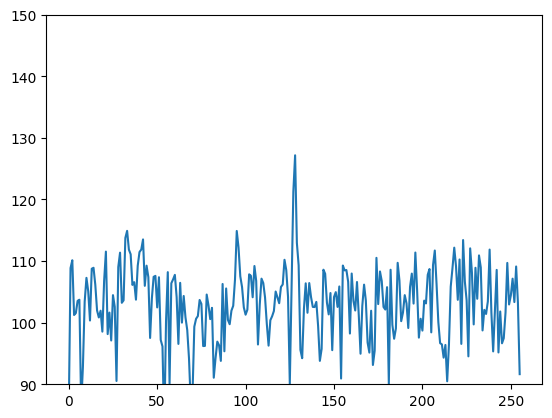

In [32]:
roteted_data =ndimage.rotate( data_doppler_window_slow,90)
plt.plot( 10*np.log(np.abs( roteted_data[137,:])))
plt.ylim(90,150)
plt.show()

<Figure size 6000x6000 with 0 Axes>

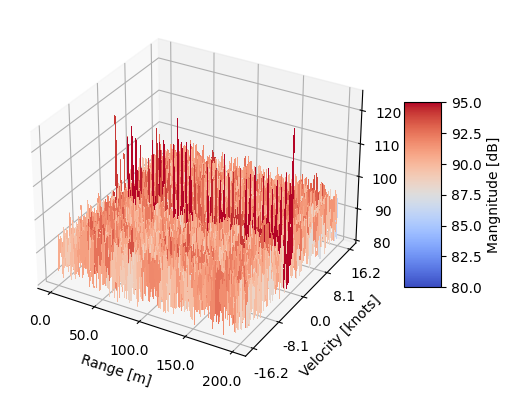

In [33]:
utils.plot_3D(data_doppler_window_slow,figname="3dDoppler_windowed",zlim_min=plot_min_3d,zlim_max=plot_max_3d)

# MTI

/Users/sondreolimb/prosjektOppgave/ProjectReportCode/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sondreolimb/prosjektOppgave/ProjectReportCode/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


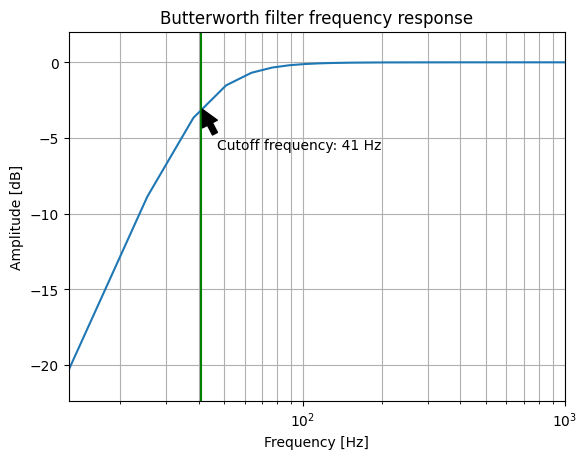

In [34]:
sos = signal.butter(2, 41, 'hp',  output='sos',fs=sample_frek)
w, h = signal.sosfreqz(sos, worN=15000000,fs = sample_frek)
plt.semilogx(w, 20 * np.log10(np.abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]') 
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.xlim(0, 1000)
plt.grid(which='both', axis='both')
plt.axvline(41, color='green') # cutoff frequency
plt.annotate('Cutoff frequency: 41 Hz', xy=(41, -3), xytext=(200, -5)
            , xycoords='data',
            
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
plt.savefig("plots/butterworth.svg",format="svg")
plt.show()

Peak: 42.662514709036124
Side loab: 43.16883327420311
RMS: 42.93411933835405
SNR: -0.2716046293179275


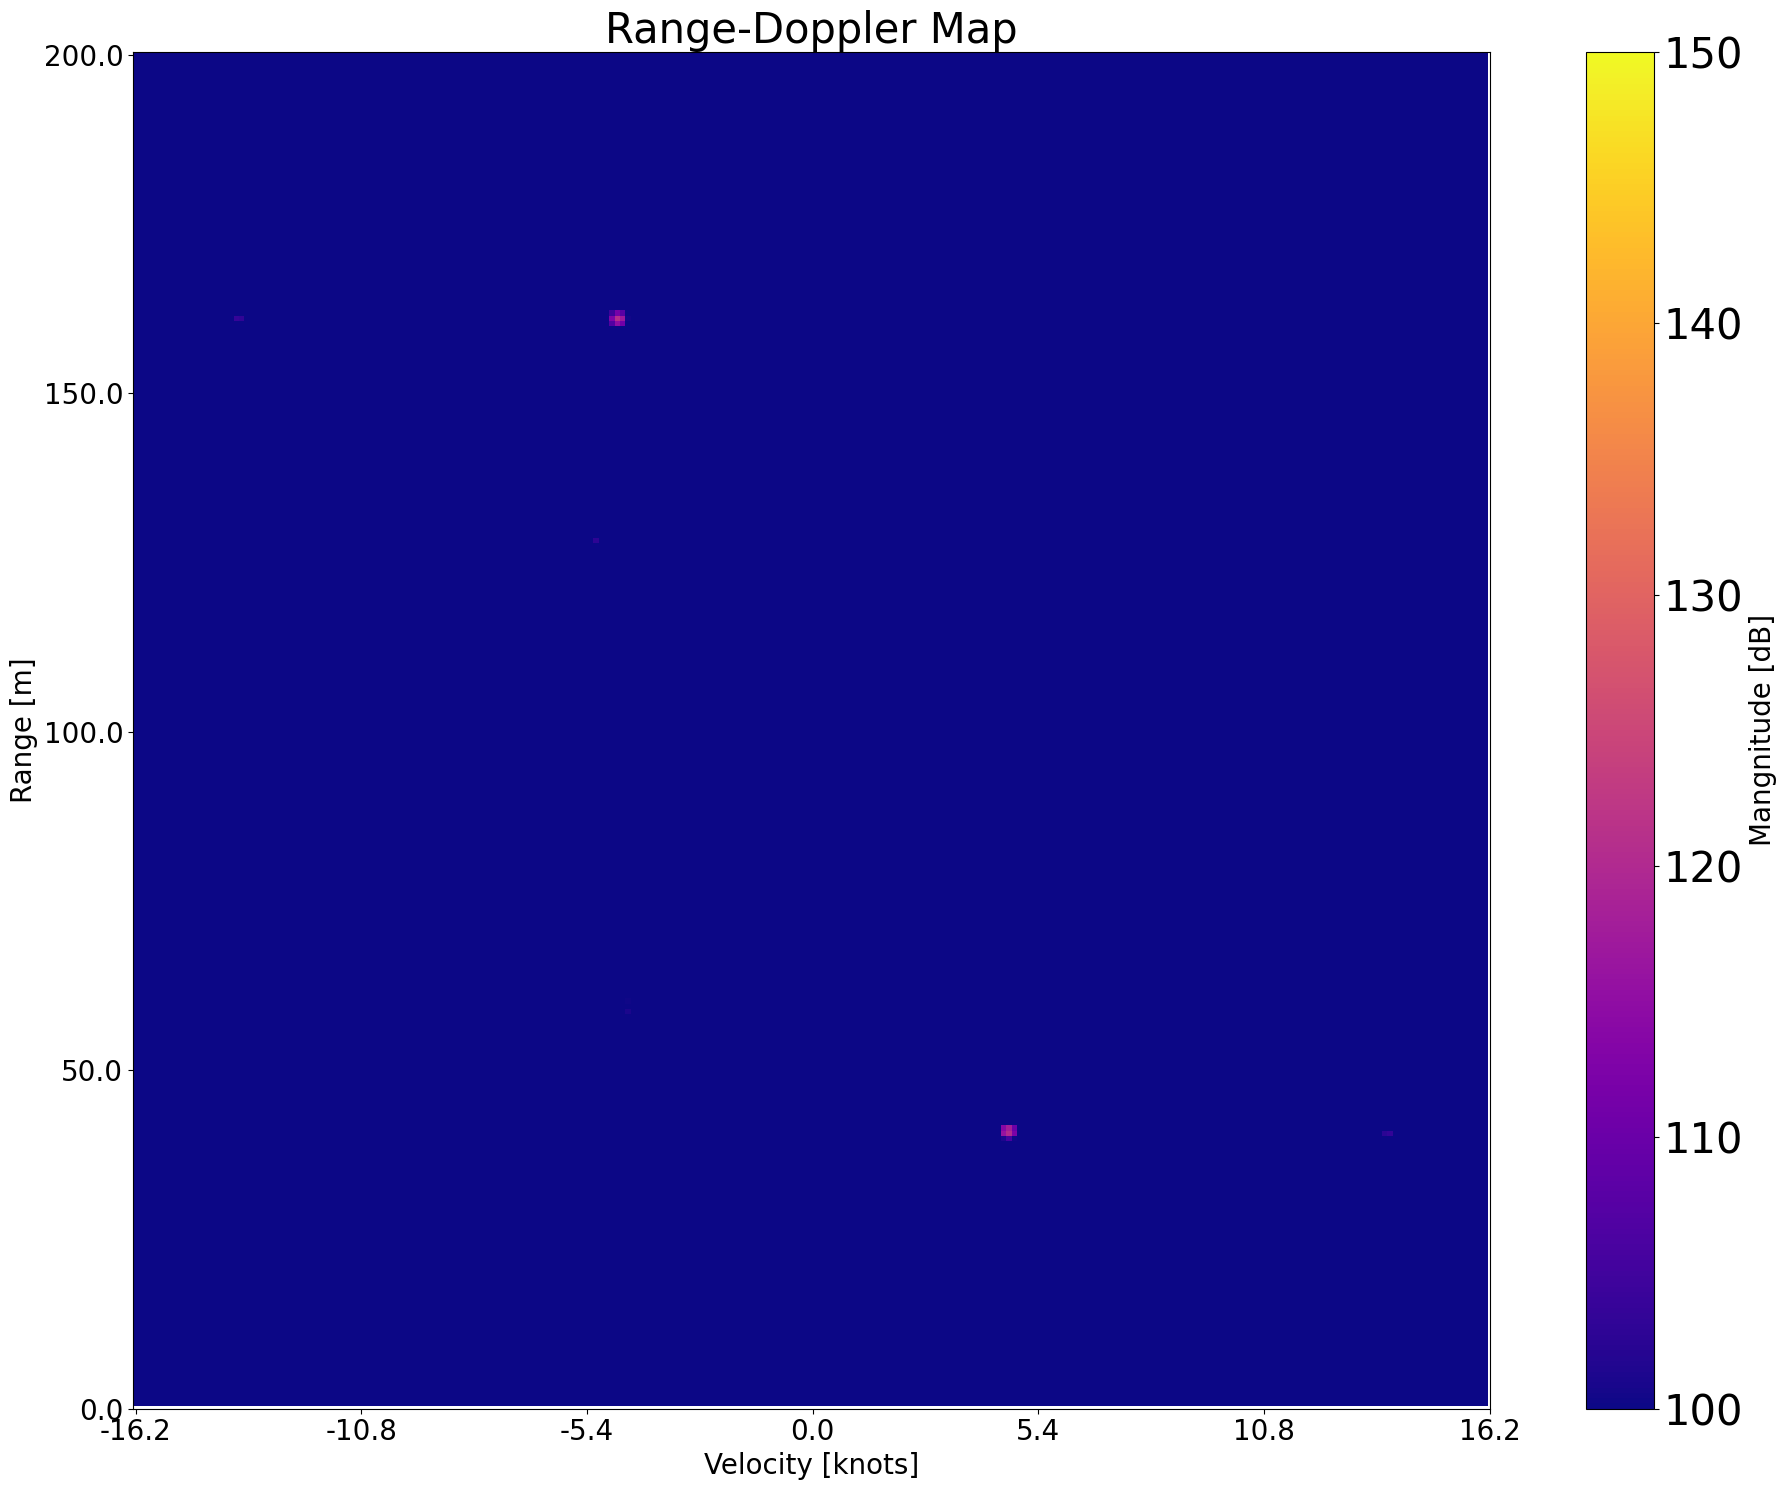

In [35]:


data_filterd = utils.MIT_filter(data_range_windowed)
data_range_baseline_window = data_range_baseline.copy()
for i in range(256):
    data_filterd[:,i] = signal.windows.hann(256)*data_filterd[:,i]
data_doppler_filterd= utils.fft_and_plot(data_filterd, axis=0, fs=sample_frek,fft_size=256,plot=True,shift =True,vmin=plot_min_doppler,vmax=plot_max_doppler, doppler= True,labels=labels,savefig=True, figname="Range-Doppler_MTI", dB=True,mode=10)


<Figure size 6000x6000 with 0 Axes>

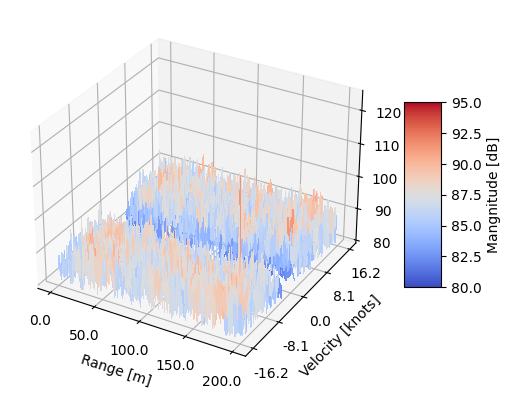

In [36]:
utils.plot_3D(data_doppler_filterd,figname="3dDoppler_MIT",zlim_min=plot_min_3d,zlim_max=plot_max_3d)

# Remove artifacts

In [37]:
# data_doppler_filterd[90:94,204:207] = 1
# data_doppler_filterd[163:170,50:54] = 1
# sns.heatmap(20*np.log(np.abs(data_doppler_filterd)),cmap="plasma")
# plt.plot()

# CFAR

In [38]:
def P_avg(P,N):
    return P/N
def alpha(N,P_FA):
    return N*(P_FA**(-1/N)-1)

def estimated_teshold(alpha,P):
    return alpha*np.abs(P)
def window_estimator(x,training_cells,training_area):    
    area = x.shape[0]*x.shape[1]
    P_total = np.sum(np.abs(x))
    P_center_square =np.sum(np.abs(x[training_cells:x.shape[0]-training_cells,training_cells:x.shape[1]-training_cells]))
    P_traning_cells = np.abs(P_total - P_center_square)
    
    return P_avg(P_traning_cells,training_area)
    



In [39]:
def CFAR_2D(data, guard_cells, training_cells, PFA):
    """_summary_

    Args:
        data (_type_): _description_
        guard_cells (_type_): _description_
        training_cells (_type_): _description_
        threshold (_type_): _description_
    """
    idx_peaks = []
    treshold_map = np.zeros(data.shape)

    window_size = guard_cells + training_cells
    
    data_cfar = np.pad(data, window_size, mode='edge')
    

    window_area = (2*window_size+1)**2
    training_area = window_area - (2*window_size+1-2*training_cells)**2
    a = alpha(training_area, PFA)
    

    for i in range(256):
        for j in range(256):
            P_training = window_estimator(data_cfar[i:i+2*window_size+1,j:j+2*window_size+1],training_cells ,training_area)
            threshold = estimated_teshold(a,P_training)
            treshold_map[i,j] = threshold
            
            if(np.abs(data[i,j]) < threshold):
                data[i,j] = 1
            else:
                idx_peaks.append([i,j])
           
    print(len(idx_peaks))
    
    #ax = sns.heatmap(np.abs(data),cmap="plasma")
    plt.figure(figsize=(20,15))
    rotated_img = ndimage.rotate(20*np.log(np.abs(data)),90) # We rotate the image so the x axis is the velocity
    plt.imshow(rotated_img,cmap="plasma")
    plt.grid(False)
        
    plt.yticks(np.linspace(0,256,5),labels=np.linspace(200,0,5))
       
    plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-16.1987,16.1987,11),2))
    cbar  = plt.colorbar()
    cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
    plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
    plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
    plt.title("CFAR",fontdict = {'fontsize' : 30})
    
            
    return data, idx_peaks, treshold_map

traning area 2160
Total detections 77
{'cords': (254, 128), 'peak': 6686613.0900437925, 'noise_est': 32791.51505424593, 'SNR': 23.094447115050475} 

{'cords': (253, 128), 'peak': 2671792.959463149, 'noise_est': 34048.730882785974, 'SNR': 18.947018722399086} 

{'cords': (50, 91), 'peak': 4551747.13508188, 'noise_est': 58505.639047813136, 'SNR': 18.909804000945822} 

{'cords': (161, 128), 'peak': 5004739.779891758, 'noise_est': 69024.18925706201, 'SNR': 18.60380187162922} 

{'cords': (204, 165), 'peak': 3817143.240322499, 'noise_est': 59757.73966412382, 'SNR': 18.05344295451628} 

{'cords': (252, 128), 'peak': 2177729.3136734352, 'noise_est': 34745.74709504783, 'SNR': 17.971022428368382} 

{'cords': (158, 128), 'peak': 4201228.822525946, 'noise_est': 67405.00359899302, 'SNR': 17.94684200079292} 

{'cords': (0, 128), 'peak': 4750092.800316593, 'noise_est': 88413.44992873832, 'SNR': 17.30183757066292} 

{'cords': (251, 128), 'peak': 1891798.5647934962, 'noise_est': 35663.23761367964, 'SNR'

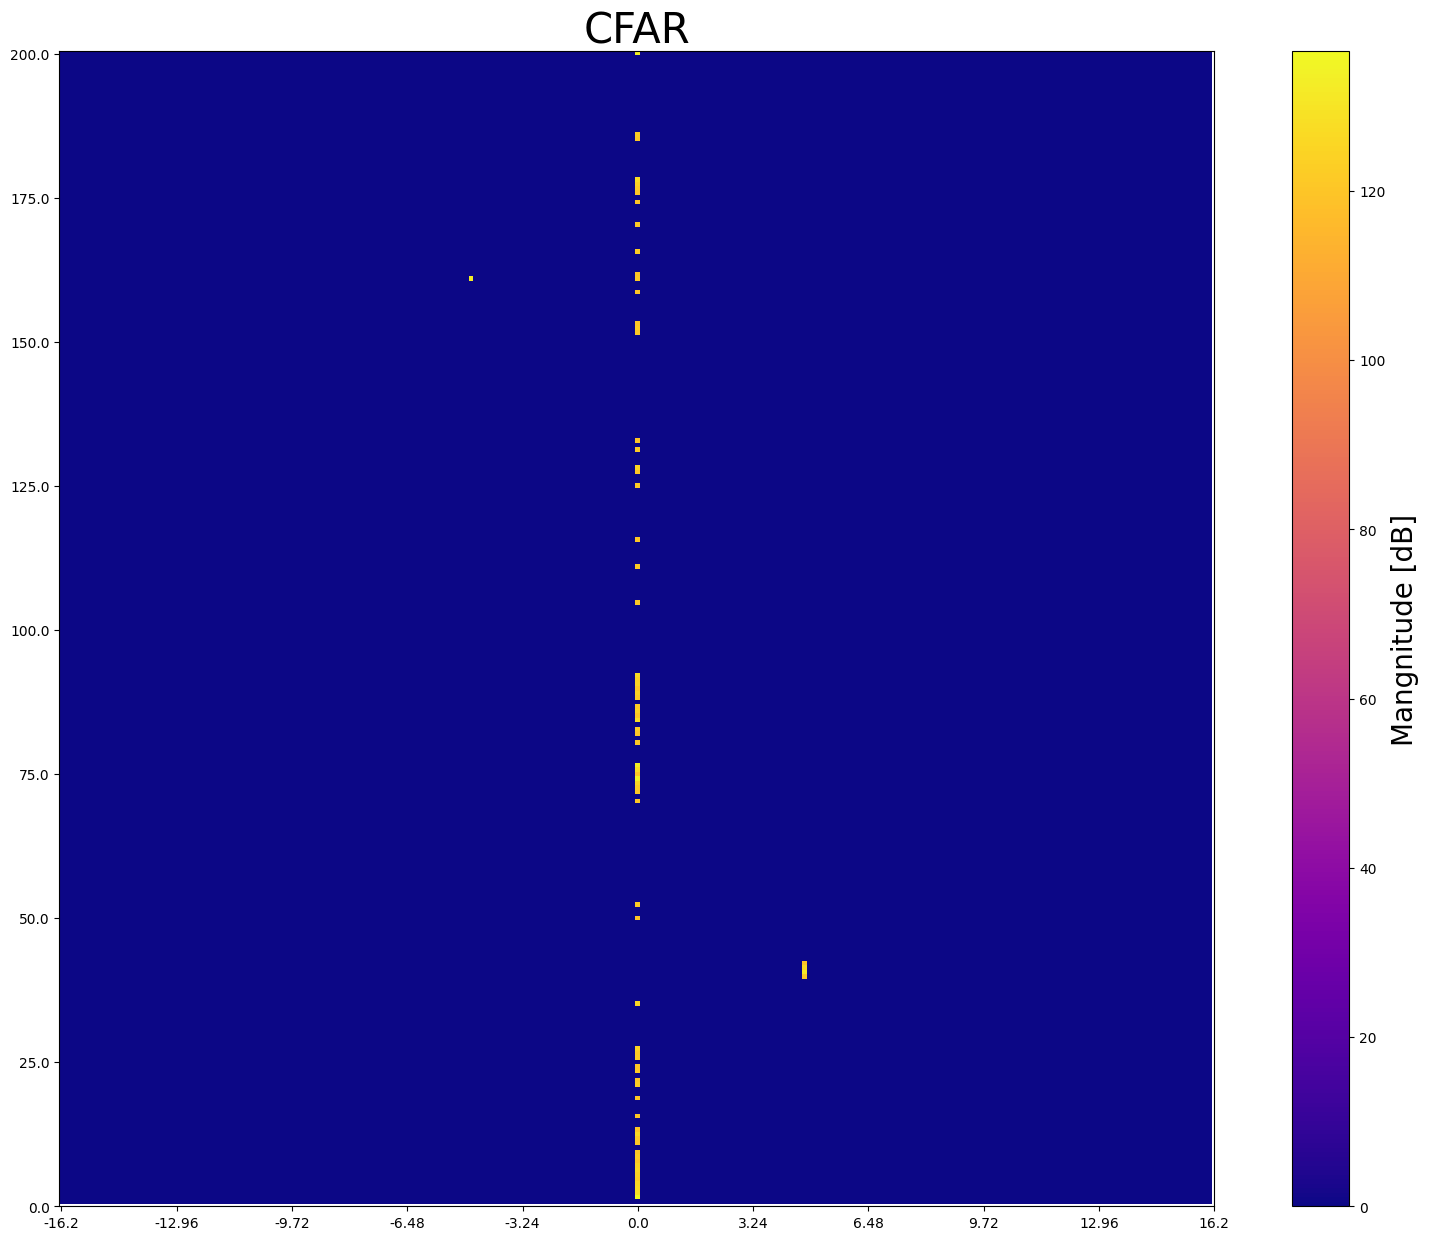

<Figure size 6000x6000 with 0 Axes>

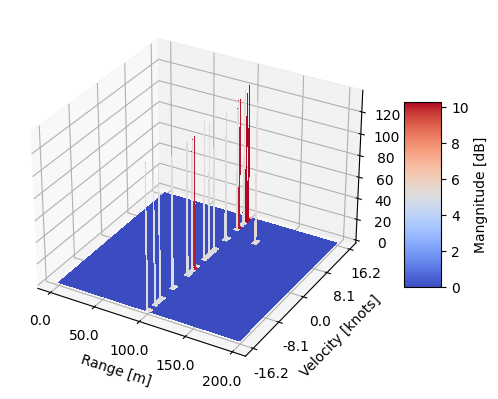

In [40]:
#data_cfar, idx_peaks, treshold_map = utils.CFAR_2D(data_doppler_filterd.copy(), 5, 15, 0.0001,plot=True, iso_axis=False)
data_cfar, idx_peaks, treshold_map = utils.CFAR_2D(data_doppler_baseline.copy(), 10, 15, 0.000001,plot=True, iso_axis=True, saveFig=True, filename ="CFAR_MTI")